In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm as log_progress
from ipywidgets import widgets # for buttons and dropdown menus
from IPython.display import display, clear_output # for buttons and dropdown menus
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

In [2]:
data = pd.read_csv('avocado.csv',parse_dates=['Date'])
data = data.sort_values(['region','type','Date'])

In [3]:
sns.set(rc={'figure.figsize':(12,8)})

In [4]:
def results_vis(f_dict,plot_type='forecast',order_by='LevelTestSetMAPE',level=True):
    """ visualize the forecast results
        leverages Jupyter widgets
    """
    def display_user_selections(ts_selection,mo_selection):
        sns.set(rc={'figure.figsize':(18,10)})
        selected_data = f_dict[ts_selection]
        if plot_type == 'forecast':
            print(ts_selection)
            selected_data.plot(models=f'top_{mo_selection}',order_by=order_by,level=level,
                               print_attr=['TestSetRMSE','TestSetR2','LevelTestSetRMSE','TestSetMAPE','LevelTestSetR2','LevelTestSetMAPE','Scaler','HyperParams','Xvars','models','Integration'])
        elif plot_type == 'test':
            print(ts_selection)
            selected_data.plot_test_set(models=f'top_{mo_selection}',order_by=order_by,include_train=52,level=level)

    def on_button_clicked(b):
        mo_selection = mo_dd.value
        ts_selection = ts_dropdown.value
        with output:
            clear_output()
            display_user_selections(ts_selection,mo_selection)
    
    all_models = models + ('weighted','avg')
    ts_dropdown = widgets.Dropdown(options=f_dict.keys(), description = 'Time Series:')
    mo_dd = widgets.Dropdown(options=range(1,len(all_models)+1), description = 'No. Models')

    # never changes
    button = widgets.Button(description="Select Time Series")
    output = widgets.Output()

    display(ts_dropdown,mo_dd)
    display(button, output)
    
    button.on_click(on_button_clicked)

In [5]:
avc = {}
for reg in data.region.unique():
    for typ in data.type.unique():
        data_slice = data.loc[(data['region'] == reg) & (data['type'] == typ)]
        load_dates = pd.date_range(start=data_slice['Date'].min(),end=data_slice['Date'].max(),freq='W') # for missing weeks, assume 0
        data_load = pd.DataFrame({'Date':load_dates})
        data_load['Vol'] = data_load.merge(data_slice,how='left',on='Date')['Total Volume'].values
        data_load.fillna(0,inplace=True)
        f = Forecaster(y=data_load['Vol'],current_dates=data_load['Date'],type=typ,region=reg)
        avc[f"{reg}-{typ}"] = f

In [6]:
# summaries
print(f'number of series to forecast: {len(avc)}')
print(f'number of actual weeks to forecast with: {len(load_dates)}')

number of series to forecast: 108
number of actual weeks to forecast with: 169


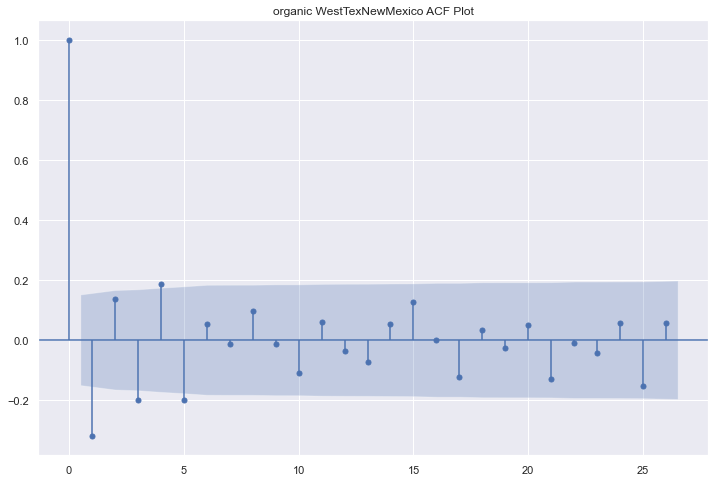

In [7]:
f.plot_acf(diffy=True,lags=26)
plt.title(f'{f.type} {f.region} ACF Plot')
plt.show()

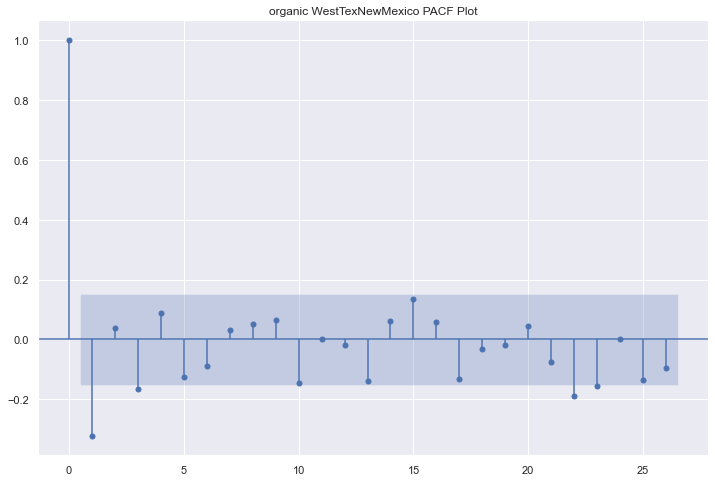

In [8]:
f.plot_pacf(diffy=True,lags=26)
plt.title(f'{f.type} {f.region} PACF Plot')
plt.show()

organic WestTexNewMexico Seasonal Decomposition


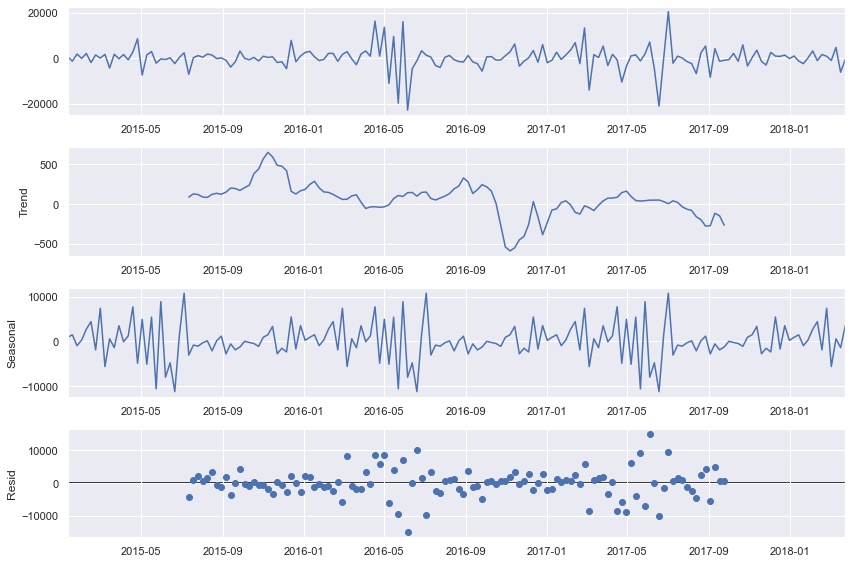

In [9]:
print(f'{f.type} {f.region} Seasonal Decomposition')
f.seasonal_decompose(diffy=True).plot()
plt.show()

In [10]:
models = ('mlr','knn','xgboost','gbt','elasticnet','mlp','prophet')
#avc = pickle.load(open('avocado_results.pckl','rb'))
for k, f in log_progress(avc.items()):
    f.generate_future_dates(52)
    f.set_test_length(26)
    f.set_validation_length(13)
    f.add_ar_terms(3)
    f.add_AR_terms((1,26))
    if not f.adf_test():
        f.diff()
    f.add_seasonal_regressors('week','month','quarter',sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()

    for m in models:
        f.set_estimator(m)
        f.tune() # by default, will pull the grid with the same name as the estimator (mlr will pull the mlr grid, etc.)
        f.auto_forecast()

    # combine models and run manually specified models of other varieties
    f.set_estimator('combo')
    f.manual_forecast(how='weighted',models=models,determine_best_by='ValidationMetricValue',call_me='weighted') # weighted average of all models based on determine_best_by
    f.manual_forecast(how='simple',models='top_5',determine_best_by='ValidationMetricValue',call_me='avg') # a simple average of the top 5 best performing models based on determine_best_by

  0%|          | 0/108 [00:00<?, ?it/s]

In [11]:
forecast_info = pd.DataFrame()
for k, f in avc.items():
    df = f.export(dfs='model_summaries',determine_best_by='LevelTestSetMAPE')
    df['Name'] = k
    df['Region'] = f.region
    df['Type'] = f.type
    forecast_info = pd.concat([forecast_info,df],ignore_index=True)
    
forecast_info.to_csv('avocado_model_summaries.csv',index=False)

In [12]:
forecast_info['LevelTestSetMAPE'].mean()

2.3717734957589744

In [13]:
forecast_info.loc[forecast_info['best_model'] == True, 'LevelTestSetMAPE'].mean()

0.1867204986901831

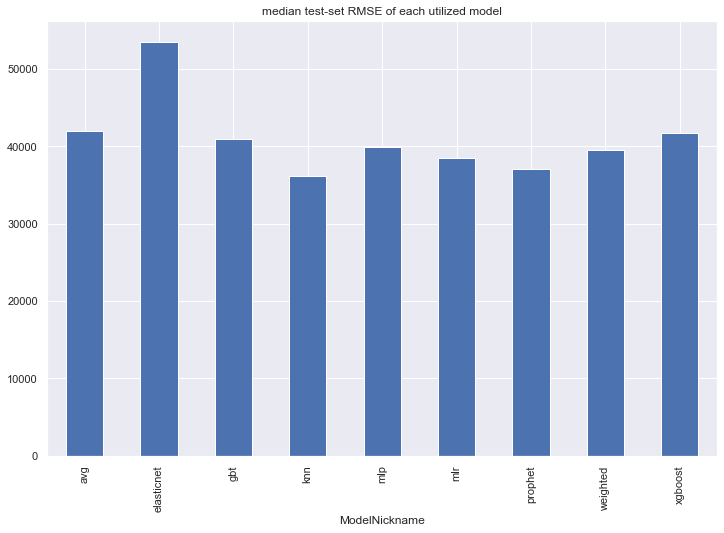

In [14]:
forecast_info.groupby('ModelNickname')['TestSetRMSE'].median().plot.bar()
plt.title('median test-set RMSE of each utilized model')
plt.show()

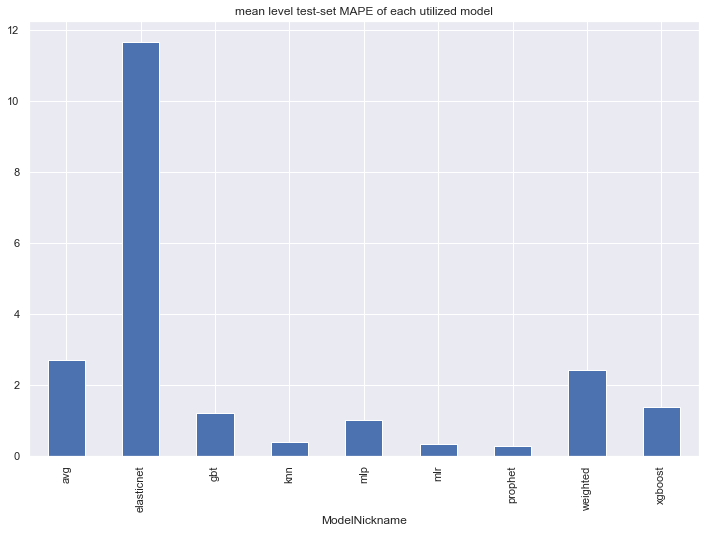

In [15]:
forecast_info.groupby('ModelNickname')['LevelTestSetMAPE'].mean().plot.bar()
plt.title('mean level test-set MAPE of each utilized model')
plt.show()

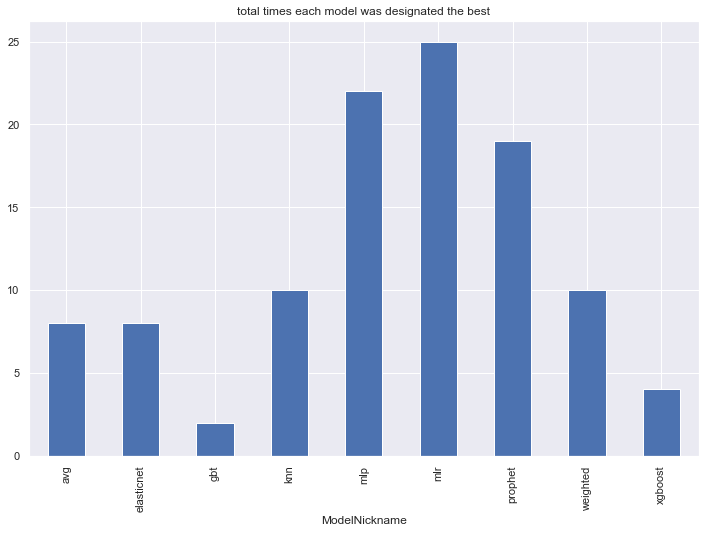

In [16]:
forecast_info.groupby('ModelNickname')['best_model'].sum().plot.bar()
plt.title('total times each model was designated the best')
plt.show()

In [17]:
results_vis(avc,'test','TestSetRMSE',level=False)

Dropdown(description='Time Series:', options=('Albany-conventional', 'Albany-organic', 'Atlanta-conventional',…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1)

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [18]:
results_vis(avc,'forecast','TestSetRMSE')

Dropdown(description='Time Series:', options=('Albany-conventional', 'Albany-organic', 'Atlanta-conventional',…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1)

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [19]:
with open('avocado_results.pckl','wb') as f:
    pickle.dump(avc,f)